# Data transformation and outlier detection

Gensor provides some simple ways to find and eliminate outliers from the data. It can also be used in combination, for example we can first transform the data and then remove outliers, what can be an effective strategy in some cases. Below we quickly get the dataset created in the previous tutorial.

Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv
Skipping file /workspaces/gensor/gensor/testdata/PB02A_plain.csv due to missing metadata.
Loading file: /workspaces/gensor/gensor/testdata/Barodiver_220427183008_BY222.csv
Loading file: /workspaces/gensor/gensor/testdata/PB01A_moni_AV319_220427183019_AV319.csv
Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv


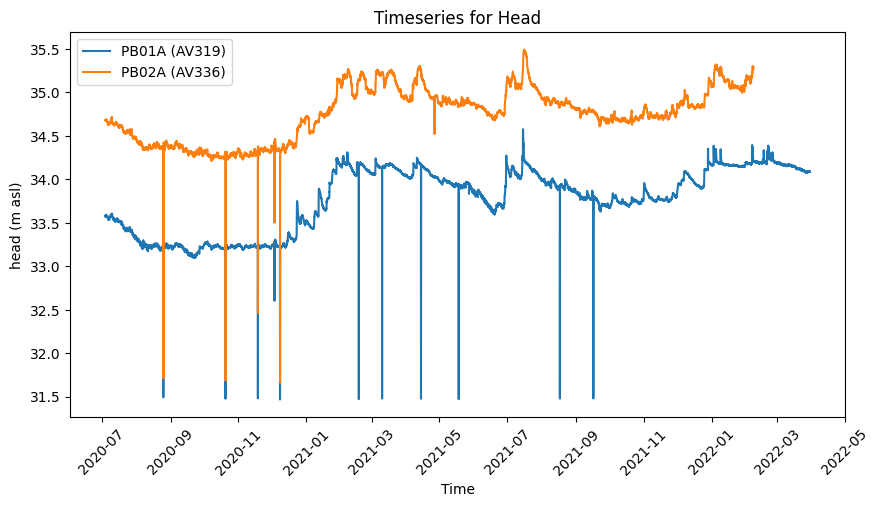

In [1]:
import gensor as gs
from gensor.testdata import all_paths, pb02a_plain

from gensor import read_from_csv

pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'

ds = read_from_csv(path=all_paths, 
                    file_format='vanessen', 
                    location_pattern=pattern)


ds2 = read_from_csv(path=pb02a_plain, 
                    file_format='plain', 
                    location='PB02A',
                    sensor='AV336')

ds.add(ds2)

baro = ds.filter(stations='Barodiver', variables='pressure')

alts = {
    "PB01A": 31.48,
    "PB02A": 31.68
    }

groundwater_ds = ds.filter(stations=alts.keys(), variables="pressure")

for ts in groundwater_ds:
    ts.sensor_alt = alts.get(ts.location)

# This is the version where we just exclude the fieldwork dates:
# fieldwork_days = {"PB01A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
#                   '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
#                   '2021-08-17', '2021-09-16'],
#                   "PB02A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
#                   '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
#                   '2021-08-17', '2021-09-16', '2021-04-26']}

# compensated_ds = gs.compensate(groundwater_ds, baro, fieldwork_dates=fieldwork_days, interpolate_method='linear')
compensated_ds = gs.compensate(groundwater_ds, baro)

compensated_ds.plot()

## Transformation

In Gensor, transformations are implemented to allow flexible data processing and scaling of time series data for normalization, trend removal, variance stabilization, etc.. These transformations are important when working with sensor data, where raw measurements may need to be adjusted to enhance interpretation.

The `Transformation` class in Gensor handles multiple types of transformations, including:

- Difference: Used to remove trends by differencing the data over a specified period.
- Logarithmic (Log): Applied to stabilize variance and reduce the impact of large outliers.
- Square Root: Another method for stabilizing variance, commonly used for data skewness.
- Box-Cox: A powerful transformation that normalizes non-normal data, often used when data contains only positive values.
- Scaling Methods (Standard, MinMax, Robust, MaxAbs): Common normalization techniques that adjust data based on its distribution, commonly used to prepare data for machine learning models.

The Timeseries class integrates this functionality, allowing application of transformations to time series data. Subsequently, user can perform operations on that transformed serie, like outlier removal, and then filter the original timeseries.

Below is an example workflow on how to use differencing to enhance outlier detection:

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB01A'}, xlabel='Time', ylabel='head (m asl)'>)

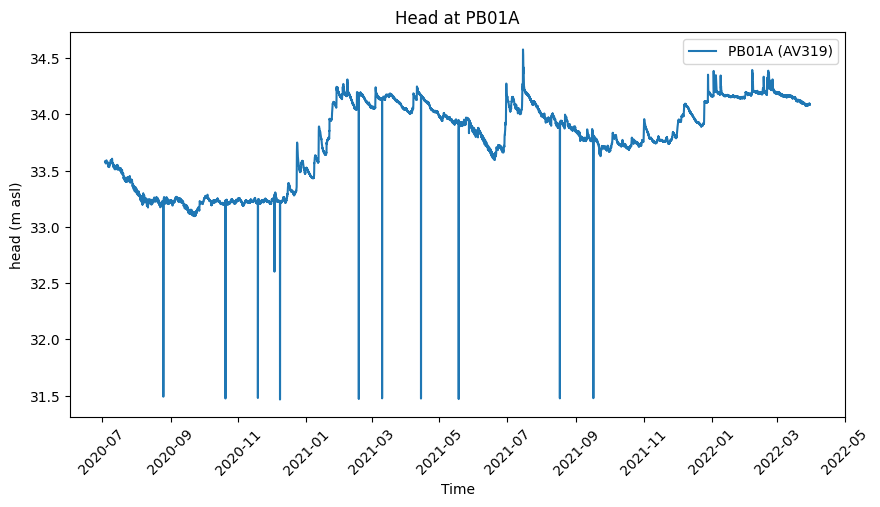

In [2]:
ts = compensated_ds[0].model_copy(deep=True)
ts.plot()

We will obtain a new Timeseries object containing only the dips in the negative direction. In the case of Kinrooi sensor data, we first are trying to eliminate records which were taken when the diver was out of the water (which means that the water column was 0). It also includes some of the records taken after, when the groudwater level was recovering from pumping.

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB01A'}, xlabel='Time', ylabel='head (m asl)'>)

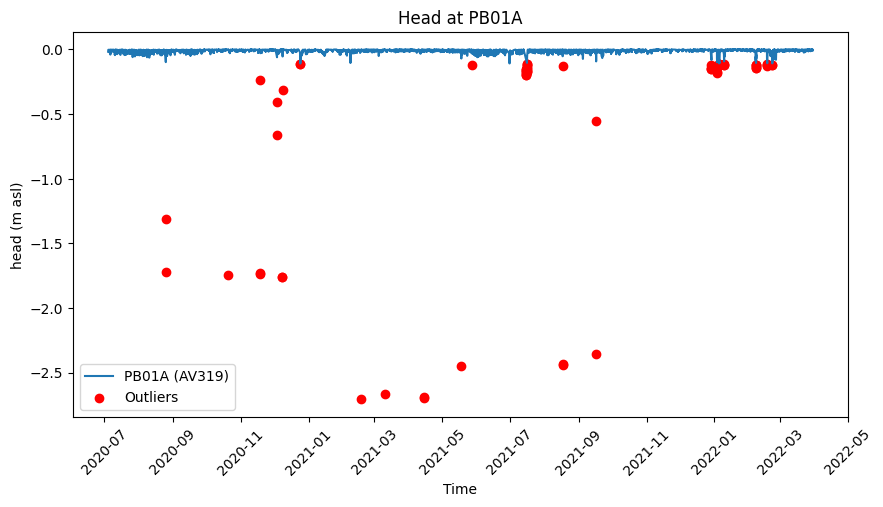

In [14]:
ts_diff = ts.transform('difference', periods=12)
ts_diff_dips = ts_diff.loc[ts_diff.ts < 0]

# we've obtained a timeseries which has identified outliers. We can use those to mask our original series.
ts_identified_outliers = ts_diff_dips.detect_outliers('zscore', threshold=1.0)
ts_identified_outliers.plot(include_outliers=True)

In [15]:
masked = ts.mask_with(ts_identified_outliers.outliers)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB01A'}, xlabel='Time', ylabel='head (m asl)'>)

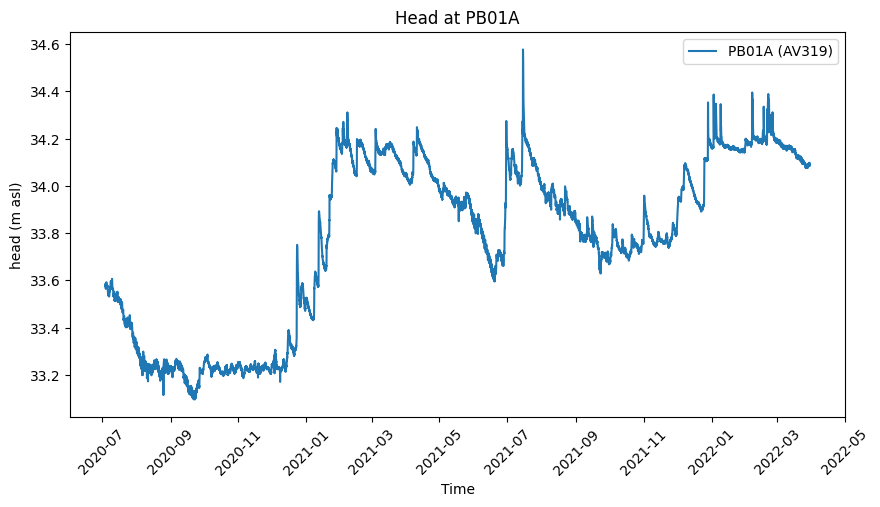

In [16]:
masked.plot()

By tweaking the paramters of each outlier detection method, we can actually quite accurately remove them from the dataset without doing it sevral times in a loop.